## API KEY

In [1]:
import requests
import base64

# Replace with your own Client ID and Client Secret
CLIENT_ID = '8a63341f5234405e9403d79f5f869cc9'
CLIENT_SECRET = '55530432bf1a4833a1b6e81d3e254905'

# Base64 encode the client ID and client secret
client_credentials = f"{CLIENT_ID}:{CLIENT_SECRET}"
client_credentials_base64 = base64.b64encode(client_credentials.encode())

# Request the access token
token_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {client_credentials_base64.decode()}'
}
data = {
    'grant_type': 'client_credentials'
}
response = requests.post(token_url, data=data, headers=headers)

if response.status_code == 200:
    access_token = response.json()['access_token']
    print("Access token obtained successfully.")
else:
    print("Error obtaining access token.")
    exit()

Access token obtained successfully.


In [2]:
pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 9.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Creating DataFrame

In [3]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth

def get_trending_playlist_data(playlist_id, access_token):
    # Set up Spotipy with the access token
    sp = spotipy.Spotify(auth=access_token)

    # Get the tracks from the playlist
    playlist_tracks = sp.playlist_tracks(playlist_id, fields='items(track(id, name, artists, album(id, name)))')

    # Extract relevant information and store in a list of dictionaries
    music_data = []
    for track_info in playlist_tracks['items']:
        track = track_info['track']
        track_name = track['name']
        artists = ', '.join([artist['name'] for artist in track['artists']])
        album_name = track['album']['name']
        album_id = track['album']['id']
        track_id = track['id']

        # Get audio features for the track
        audio_features = sp.audio_features(track_id)[0] if track_id != 'Not available' else None

        # Get release date of the album
        try:
            album_info = sp.album(album_id) if album_id != 'Not available' else None
            release_date = album_info['release_date'] if album_info else None
        except:
            release_date = None

        # Get popularity of the track
        try:
            track_info = sp.track(track_id) if track_id != 'Not available' else None
            popularity = track_info['popularity'] if track_info else None
        except:
            popularity = None

        # Add additional track information to the track data
        track_data = {
            'Track Name': track_name,
            'Artists': artists,
            'Album Name': album_name,
            'Album ID': album_id,
            'Track ID': track_id,
            'Popularity': popularity,
            'Release Date': release_date,
            'Duration (ms)': audio_features['duration_ms'] if audio_features else None,
            'Explicit': track_info.get('explicit', None),
            'External URLs': track_info.get('external_urls', {}).get('spotify', None),
            'Danceability': audio_features['danceability'] if audio_features else None,
            'Energy': audio_features['energy'] if audio_features else None,
            'Key': audio_features['key'] if audio_features else None,
            'Loudness': audio_features['loudness'] if audio_features else None,
            'Mode': audio_features['mode'] if audio_features else None,
            'Speechiness': audio_features['speechiness'] if audio_features else None,
            'Acousticness': audio_features['acousticness'] if audio_features else None,
            'Instrumentalness': audio_features['instrumentalness'] if audio_features else None,
            'Liveness': audio_features['liveness'] if audio_features else None,
            'Valence': audio_features['valence'] if audio_features else None,
            'Tempo': audio_features['tempo'] if audio_features else None,
            # Add more attributes as needed
        }

        music_data.append(track_data)

    # Create a pandas DataFrame from the list of dictionaries
    df = pd.DataFrame(music_data)

    return df

## Choosing Playlist

In [4]:
playlist_id = '5ABHKGoOzxkaa28ttQV9sE' #That's the top 100 popular songs on Spotify

# Call the function to get the music data from the playlist and store it in a DataFrame
music_df = get_trending_playlist_data(playlist_id, access_token)

# Display the DataFrame
print(music_df)

                                       Track Name                     Artists  \
0                                 Blinding Lights                  The Weeknd   
1                                    Shape of You                  Ed Sheeran   
2                               Someone You Loved               Lewis Capaldi   
3                                       As It Was                Harry Styles   
4   Sunflower - Spider-Man: Into the Spider-Verse       Post Malone, Swae Lee   
..                                            ...                         ...   
95                           Too Good At Goodbyes                   Sam Smith   
96                                   Stay With Me                   Sam Smith   
97                                    Daydreaming                     Bruklin   
98                                      Kill Bill                         SZA   
99                      Havana (feat. Young Thug)  Camila Cabello, Young Thug   

                           

In [5]:
print(music_df.isnull().sum())

Track Name          0
Artists             0
Album Name          0
Album ID            0
Track ID            0
Popularity          0
Release Date        0
Duration (ms)       0
Explicit            0
External URLs       0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
dtype: int64


## Tunning Features for Recommendations

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

data = music_df

In [7]:
# Function to calculate weighted popularity scores based on release date
def calculate_weighted_popularity(release_date):
    # Convert the release date to datetime object
    release_date = datetime.strptime(release_date, '%Y-%m-%d')

    # Calculate the time span between release date and today's date
    time_span = datetime.now() - release_date

    # Calculate the weighted popularity score based on time span (e.g., more recent releases have higher weight)
    weight = 1 / (time_span.days + 1)
    return weight

In [8]:
# Normalize the music features using Min-Max scaling
scaler = MinMaxScaler()
music_features = music_df[['Danceability', 'Energy', 'Key', 
                           'Loudness', 'Mode', 'Speechiness', 'Acousticness',
                           'Instrumentalness', 'Liveness', 'Valence', 'Tempo']].values
music_features_scaled = scaler.fit_transform(music_features)

In [9]:
# a function to get content-based recommendations based on music features
def content_based_recommendations(input_song_name, num_recommendations=5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get the index of the input song in the music DataFrame
    input_song_index = music_df[music_df['Track Name'] == input_song_name].index[0]

    # Calculate the similarity scores based on music features (cosine similarity)
    similarity_scores = cosine_similarity([music_features_scaled[input_song_index]], music_features_scaled)

    # Get the indices of the most similar songs
    similar_song_indices = similarity_scores.argsort()[0][::-1][1:num_recommendations + 1]

    # Get the names of the most similar songs based on content-based filtering
    content_based_recommendations = music_df.iloc[similar_song_indices][['Track Name', 'Artists', 'Album Name', 'Release Date', 'Popularity']]

    return content_based_recommendations

In [10]:
def hybrid_recommendations(input_song_name, num_recommendations=5, alpha=0.5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get content-based recommendations
    content_based_rec = content_based_recommendations(input_song_name, num_recommendations)

    # Get the popularity score of the input song
    popularity_score = music_df.loc[music_df['Track Name'] == input_song_name, 'Popularity'].values[0]

    # Calculate the weighted popularity score
    weighted_popularity_score = popularity_score * calculate_weighted_popularity(music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0])

    # Create a DataFrame for the input song
    input_song_data = {
        'Track Name': [input_song_name],
        'Artists': [music_df.loc[music_df['Track Name'] == input_song_name, 'Artists'].values[0]],
        'Album Name': [music_df.loc[music_df['Track Name'] == input_song_name, 'Album Name'].values[0]],
        'Release Date': [music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0]],
        'Popularity': [weighted_popularity_score]
    }
    input_song_df = pd.DataFrame(input_song_data)

    # Concatenate the input song DataFrame with content-based recommendations
    hybrid_recommendations = pd.concat([content_based_rec, input_song_df], ignore_index=True)

    # Sort the hybrid recommendations based on weighted popularity score
    hybrid_recommendations = hybrid_recommendations.sort_values(by='Popularity', ascending=False)

    # Remove the input song from the recommendations
    hybrid_recommendations = hybrid_recommendations[hybrid_recommendations['Track Name'] != input_song_name]

    return hybrid_recommendations

## Recommendation Song List

In [11]:
input_song_name = "Blinding Lights"
recommendations = hybrid_recommendations(input_song_name, num_recommendations=5)
print(f"Hybrid recommended songs for '{input_song_name}':")
print(recommendations.to_string(index=False))

Hybrid recommended songs for 'Blinding Lights':
                      Track Name                                                     Artists             Album Name Release Date  Popularity
                  Mr. Brightside                                                 The Killers               Hot Fuss         2004        85.0
Can't Hold Us (feat. Ray Dalton) Macklemore, Ryan Lewis, Macklemore & Ryan Lewis, Ray Dalton              The Heist   2012-10-09        76.0
       STAY (with Justin Bieber)                                The Kid LAROI, Justin Bieber  F*CK LOVE 3: OVER YOU   2021-07-23        18.0
                          Demons                                             Imagine Dragons Night Visions (Deluxe)   2012-09-04        18.0
         Wake Me Up - Radio Edit                                                      Avicii                   True   2013-01-01         4.0


In [12]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select relevant audio features
audio_features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 
                  'Speechiness', 'Acousticness', 'Instrumentalness', 
                  'Liveness', 'Valence', 'Tempo']

# Filter the dataset to keep only the required columns
music_features = music_df[audio_features].values

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
music_features_scaled = scaler.fit_transform(music_features)

# Define the sequence length for the RNN (e.g., 5 songs in a sequence)
sequence_length = 5

# Create sequences and targets
X, y = [], []

for i in range(len(music_features_scaled) - sequence_length):
    X.append(music_features_scaled[i:i + sequence_length])  # Sequence of features
    y.append(music_features_scaled[i + sequence_length])    # Target is the next song's features

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}, {y_train.shape}")
print(f"Testing shape: {X_test.shape}, {y_test.shape}")


Training shape: (76, 5, 11), (76, 11)
Testing shape: (19, 5, 11), (19, 11)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the RNN model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, len(audio_features)), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(len(audio_features), activation='linear')  # Output layer predicts the next song's features
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
model.summary()


2024-11-19 09:51:13.748172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 09:51:13.748332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 09:51:13.901386: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,235 (125.92 KB)

 Trainable params: 32,235 (125.92 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - loss: 0.2640 - mae: 0.3913 - val_loss: 0.2311 - val_mae: 0.3681
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2562 - mae: 0.3891 - val_loss: 0.2143 - val_mae: 0.3540
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2323 - mae: 0.3707 - val_loss: 0.1947 - val_mae: 0.3383
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2100 - mae: 0.3519 - val_loss: 0.1714 - val_mae: 0.3190
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1889 - mae: 0.3394 - val_loss: 0.1438 - val_mae: 0.2966
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1524 - mae: 0.3058 - val_loss: 0.1139 - val_mae: 0.2681
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1315 - mae: 0.2867 - val_loss: 0.0922 - val_mae: 0.2422
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1032 - mae: 0.2547 - val_loss: 0.0946 - val_mae: 0.2326
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1131 - mae: 0.2651 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0792 - mae: 0.2070
Test Loss: 0.07917792350053787
Test Mean Absolute Error: 0.20699328184127808


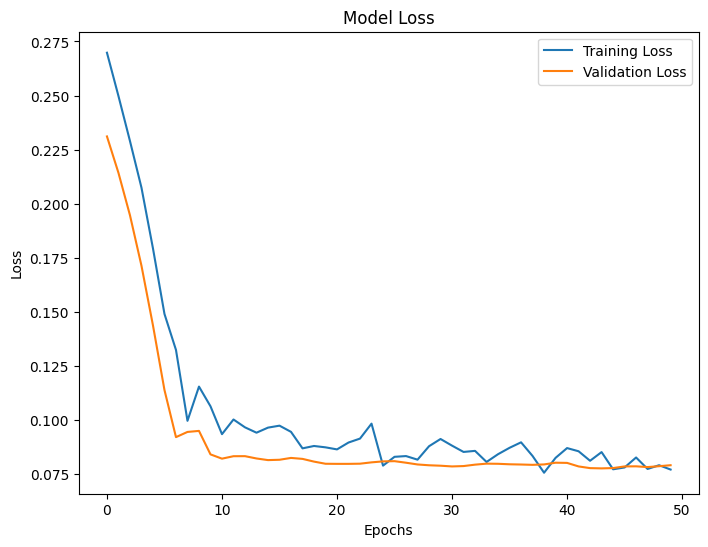

In [15]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Mean Absolute Error: {mae}")

# Plot training vs validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
# Predict the next song's features based on a sequence of input songs
def predict_next_song(input_sequence, model, scaler):
    # Ensure input_sequence is scaled and matches the input shape
    input_sequence_scaled = scaler.transform(input_sequence)
    input_sequence_scaled = np.array([input_sequence_scaled])  # Add batch dimension
    predicted_features_scaled = model.predict(input_sequence_scaled)

    # Inverse transform the predicted features to original scale
    predicted_features = scaler.inverse_transform(predicted_features_scaled)
    return predicted_features

# Example: Use the last sequence from the test set for prediction
input_sequence = music_features[-sequence_length:]
predicted_features = predict_next_song(input_sequence, model, scaler)

print("Predicted Features:", predicted_features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Predicted Features: [[ 6.1735499e-01  5.8294332e-01  5.4086046e+00 -6.6258693e+00
   5.9310007e-01  7.7019468e-02  1.9790903e-01  6.8449271e-03
   1.6974239e-01  4.6794292e-01  1.1590675e+02]]


In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to get the features of a song by its name
def get_song_features(song_name, music_df, audio_features):
    song_row = music_df[music_df['Track Name'] == song_name]
    if song_row.empty:
        raise ValueError("Song not found in the dataset")
    return song_row[audio_features].values[0]


In [18]:
# Function to recommend next songs based on input song name
def recommend_next_songs(input_song_name, model, music_df, audio_features, sequence_length=5, num_recommendations=5):
    # Get the input song's features
    input_features = get_song_features(input_song_name, music_df, audio_features)
    
    # Initialize the sequence with the input song's features
    input_sequence = [input_features]
    
    # List to hold the recommended songs and track duplicates
    recommended_songs = []
    seen_songs = set([input_song_name])  # Start with the current song already in the seen list
    
    # Iterate to generate the required number of recommendations
    iteration_count = 0
    while len(recommended_songs) < num_recommendations and iteration_count < 20:  # Limit iterations to avoid infinite loops
        iteration_count += 1
        
        # Ensure the sequence length is within bounds
        if len(input_sequence) > sequence_length:
            input_sequence = input_sequence[1:]  # Keep only the last 'sequence_length' songs
        
        # Prepare the input sequence for the model
        input_sequence_scaled = scaler.transform(np.array(input_sequence))  # Scale the sequence
        input_sequence_scaled = np.array([input_sequence_scaled])  # Add batch dimension
        
        # Predict the next song's features
        predicted_features_scaled = model.predict(input_sequence_scaled)
        
        # Inverse transform the predicted features to the original scale
        predicted_features = scaler.inverse_transform(predicted_features_scaled)
        
        # Find the closest song in the dataset based on cosine similarity
        similarities = cosine_similarity(predicted_features, music_df[audio_features].values)
        
        # Find the index of the most similar song
        closest_song_index = np.argmax(similarities)
        
        # Get the recommended song's name and URL
        recommended_song_name = music_df['Track Name'].iloc[closest_song_index]
        recommended_song_url = music_df['External URLs'].iloc[closest_song_index]
        
        # Avoid recommending the same song again
        if recommended_song_name not in seen_songs:
            recommended_songs.append((recommended_song_name, recommended_song_url))
            seen_songs.add(recommended_song_name)
        
        # Update the sequence with the predicted features
        input_sequence.append(predicted_features[0])
    
    # Fallback: If still fewer recommendations, pick the closest songs based on cosine similarity from the entire dataset
    if len(recommended_songs) < num_recommendations:
        all_songs = music_df['Track Name'].tolist()
        remaining_songs = [song for song in all_songs if song not in seen_songs]
        for song in remaining_songs[:num_recommendations - len(recommended_songs)]:
            song_index = music_df[music_df['Track Name'] == song].index[0]
            recommended_song_url = music_df['External URLs'].iloc[song_index]
            recommended_songs.append((song, recommended_song_url))
    
    return recommended_songs

# Example: Get 5 recommendations based on a specific song name
input_song_name = "Blinding Lights"  # Replace with an actual song name from your dataset
recommended_songs = recommend_next_songs(input_song_name, model, music_df, audio_features, sequence_length=5, num_recommendations=5)

# Display recommended songs (only title and URL)
if recommended_songs:
    print(f"Recommended songs after '{input_song_name}':")
    for song, url in recommended_songs:
        print(f"{song} - {url}")
else:
    print("No recommendations found.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Recommended songs after 'Blinding Lights':
Bohemian Rhapsody - Remastered 2011 - https://open.spotify.com/track/4u7EnebtmKWzUH433cf5Qv
Photograph - https://open.spotify.com/track/1HNkqx9Ahdgi1Ixy2xkKkL
Shape of You - https://open.spotify.c

In [19]:
# Save your model in Keras (TensorFlow)
model.save('my_model.h5')  # Saves the model in .h5 format
